# Imports

In [1]:
!pip install pycocotools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 10.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import copy
import xml.etree.ElementTree as ET
import albumentations as A
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms.functional as tf
from torchvision.models.detection.ssd import SSDHead,det_utils
from torchvision.models.detection import ssdlite320_mobilenet_v3_large
from torchvision.models.detection import SSDLite320_MobileNet_V3_Large_Weights
import pycocotools
import torchmetrics
from torchmetrics.detection import MeanAveragePrecision

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
np.random.seed(42)
torch.manual_seed(42)

# Configuration

In [4]:
img_dir="/kaggle/input/emds7-1/EMDS7_Preprocessed/EMDS7_Preprocessed"
annot_dir="/kaggle/input/emds-xml/EMDS7xml"
map_file="/kaggle/input/emds7-1/class_mapping.csv"

classes=['background','G001','G002','G003','G004','G005','G006','G007','G008',
         'G009','G010','G011','G012','G013','G014','G015','G016','G017','G018',
         'G019','G020','G021','G022','G023','G024','G025','G026','G027','G028',
         'G029','G030','G031','G032','G033','G034','G035','G036','G037','G038',
         'G039','G040','G041']

device="cuda" if torch.cuda.is_available() else "cpu"
batch_size=4
epochs=50
learning_rate=5e-5

model_weights_file="model.pth"

threshold=0.30
iou_threshold=0.70

# Exploratory Data Analysis

**There are 2421 images of which 2365 images has their annotation files, bounding box annotation is provided for G001-G041 miicroorganism. There are large number of unidentified objects labeled as unknowm for now they have been ignored. Images have two distribution (768,1024) and (15,2048) with latter being twice then former and having aspect ratio of 0.75 . The images are resized to (750,1000)**

In [5]:
img_files=[]
for dirname in os.listdir(img_dir):
    for img_path in os.listdir(os.path.join(img_dir,dirname)):
        img_files.append(img_path.split(".")[0])
        
annot_files=[]
for annot_path in os.listdir(annot_dir):
    annot_files.append(annot_path.split(".")[0])
    
print(f"No of images:{len(img_files)}")
print(f"No of annotation files: {len(annot_files)}")

No of images:2421
No of annotation files: 2365


In [6]:
img_with_annot=[file for file in img_files if file in annot_files]
img_without_annot=[file for file in img_files if file not in annot_files]

print(f"No of images with annotation files: {len(img_with_annot)}")
print(f"No of images without annotation files: {len(img_without_annot)}")

No of images with annotation files: 2365
No of images without annotation files: 56


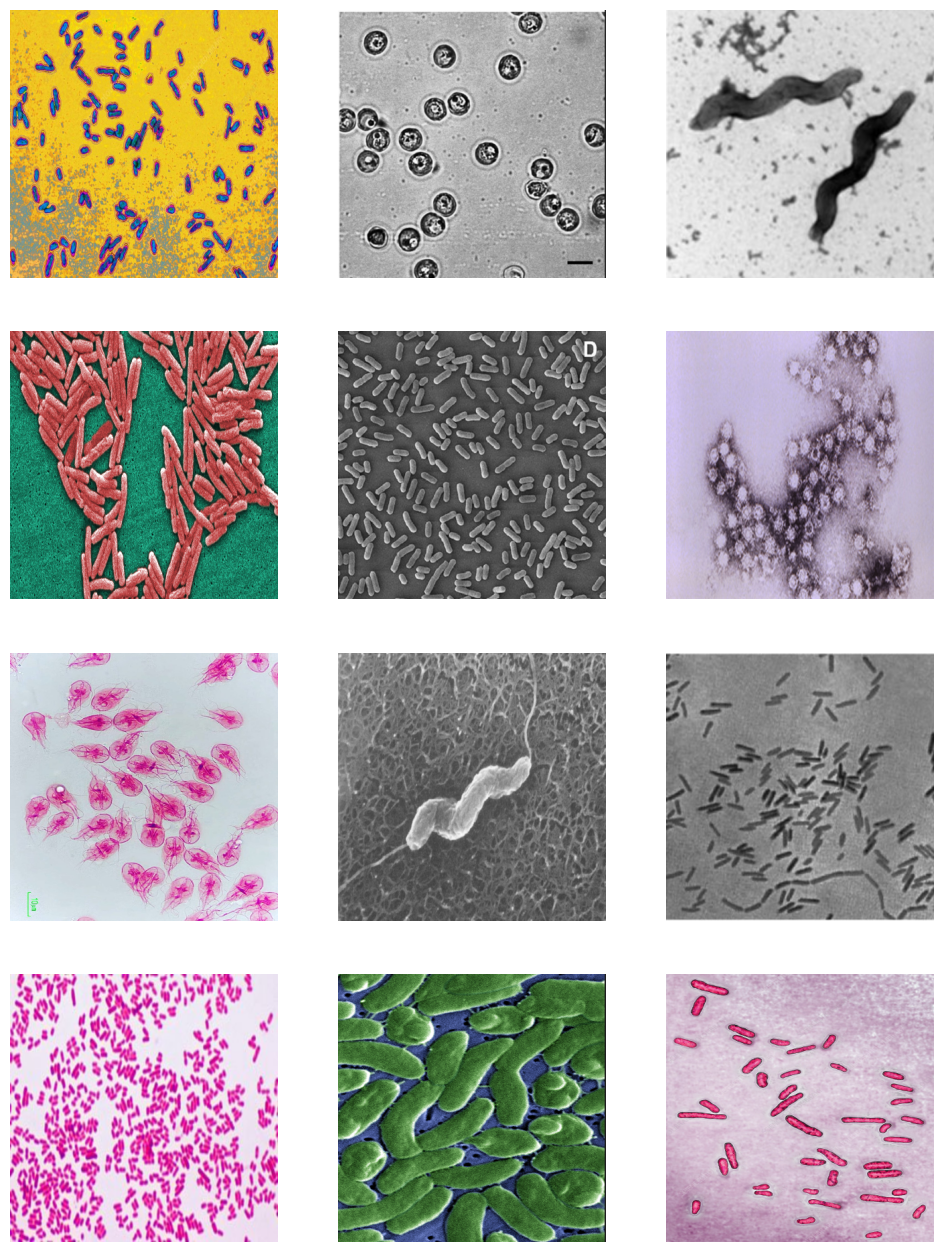

In [7]:
fig,axes=plt.subplots(4,3,figsize=(12,16))
idxs=np.random.choice(len(img_without_annot),12,False)

for i,idx in enumerate(idxs):
    img_folder=img_without_annot[idx].split("-")[0]+"-"+img_without_annot[idx].split("-")[1]
    img_name=img_without_annot[idx]+".png"
    
    img_pth=os.path.join(img_dir,img_folder,img_name)
    img=cv2.imread(img_pth)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(400,400))
    
    axes[i//3,i%3].imshow(img)
    axes[i//3,i%3].axis("off")

## Image Dimension Analysis

In [8]:
height=[]
width=[]

for img_name in img_with_annot:
    img_folder=img_name.split("-")[0]+"-"+img_name.split("-")[1]
    img_name=img_name+".png"
    img_pth=os.path.join(img_dir,img_folder,img_name)
    img=cv2.imread(img_pth)
    
    height.append(img.shape[0])
    width.append(img.shape[1])

Height: (array([ 768,  769, 1536]), array([ 667,  610, 1088]))
Width: (array([1024, 1025, 2048]), array([ 630,  647, 1088]))


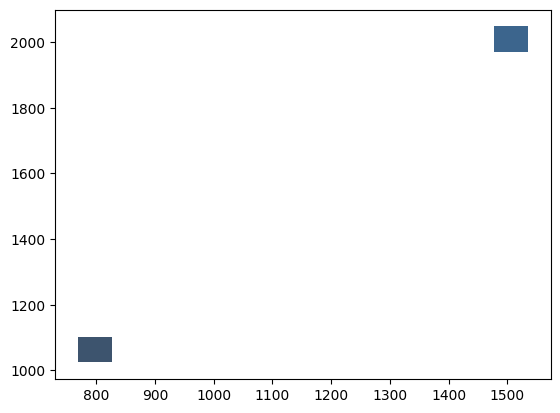

In [9]:
print(f"Height: {np.unique(height,return_counts=True)}")
print(f"Width: {np.unique(width,return_counts=True)}")
sns.histplot(x=height,y=width);

# Utility Function

In [10]:
def parse_xml(annot_path):
    tree=ET.parse(annot_path)
    root=tree.getroot()
    
    boxes=[]
    labels=[]
    
    for obj in root.findall("object"):
        label=obj.find("name").text
        if label!="unknown":
            bbox=obj.find("bndbox")
            xmin=int(bbox.find("xmin").text)
            ymin=int(bbox.find("ymin").text)
            xmax=int(bbox.find("xmax").text)
            ymax=int(bbox.find("ymax").text)
            
            boxes.append([xmin,ymin,xmax,ymax])
            labels.append(classes.index(label))
            
    return boxes,labels

# Data Augmentation

In [11]:
train_transform=A.Compose([A.OneOf([A.HorizontalFlip(),
                                    A.VerticalFlip()],p=1),
                           A.ShiftScaleRotate(rotate_limit=5,value=0,
                                              border_mode=cv2.BORDER_CONSTANT),
                           A.OneOf(
                                   [A.CLAHE(),
                                    A.RandomBrightnessContrast(),
                                    A.HueSaturationValue()],p=1),
                           A.GaussNoise(),
                           A.Resize(height=750,width=1000)],
                          bbox_params=A.BboxParams(format="pascal_voc",
                                                   label_fields=["labels"]))
                          
val_transform=A.Compose([A.Resize(height=750,width=1000)],
                          bbox_params=A.BboxParams(format="pascal_voc",
                                                   label_fields=["labels"]))

# Custom Dataset

In [12]:
class Microorganism(Dataset):
    def __init__(self,img_dir,annot_dir,filename_list,classes,transform=None):
        super().__init__()
        self.img_dir=img_dir
        self.annot_dir=annot_dir
        self.filename_list=sorted(filename_list)
        self.classes=classes
        self.transform=transform
        
    def __len__(self):
        return len(self.filename_list)
    
    def __getitem__(self,idx):
        img_name=self.filename_list[idx]
        img_folder=img_name.split("-")[0]+"-"+img_name.split("-")[1]
        img_pth=os.path.join(self.img_dir,img_folder,img_name+".png")
        img=cv2.imread(img_pth)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        
        annot_path=os.path.join(self.annot_dir,img_name+".xml")
        boxes,labels=parse_xml(annot_path)
        
        if self.transform is not None:
            transformed=self.transform(image=img,bboxes=boxes,labels=labels)
            img=transformed["image"]
            boxes=transformed["bboxes"]
            labels=transformed["labels"]
            
        if len(np.array(boxes).shape)!=2 or np.array(boxes).shape[-1]!=4:
            boxes=[[0.0,0.0,1.0,1.0]]
            labels=[0]
                
        img=tf.to_tensor(img)
        img=img.to(dtype=torch.float32)
        target={}
        target["boxes"]=torch.tensor(boxes,dtype=torch.float32)
        target["labels"]=torch.tensor(labels,dtype=torch.int64)
        target["id"]=torch.tensor(idx)
            
        return img,target

In [13]:
train_ds=Microorganism(img_dir,annot_dir,img_with_annot,classes,train_transform)
val_ds=Microorganism(img_dir,annot_dir,img_with_annot,classes,val_transform)

In [14]:
idxs=list(range(len(train_ds)))

np.random.shuffle(idxs)
train_idx=idxs[:int(0.85*len(train_ds))]
val_idx=idxs[int(0.85*len(train_ds)):]

train_ds=Subset(train_ds,train_idx)
val_ds=Subset(val_ds,val_idx)

# Data Visualization

In [15]:
def show_bbox(img,target,color=(255,0,0),detection=False):
    img=np.transpose(img.cpu().numpy(),(1,2,0))
    boxes=target["boxes"].cpu().numpy().astype("int")
    labels=target["labels"].cpu().numpy()
    if detection:
        scores=target["scores"].cpu().numpy()
        
    img=img.copy()
    for i,box in enumerate(boxes):
        if detection:
            text=classes[int(labels[i])]+f": {scores[i]:.2f}"
        else:
            text=classes[int(labels[i])]

        cv2.rectangle(img,(box[0],box[1]),(box[2],box[3]),color,5)
        y=box[1]-40 if box[1]-40>40 else box[1]+40
        cv2.putText(img,text,(box[0],y),cv2.FONT_HERSHEY_SIMPLEX,1,color,5)
        
    return img

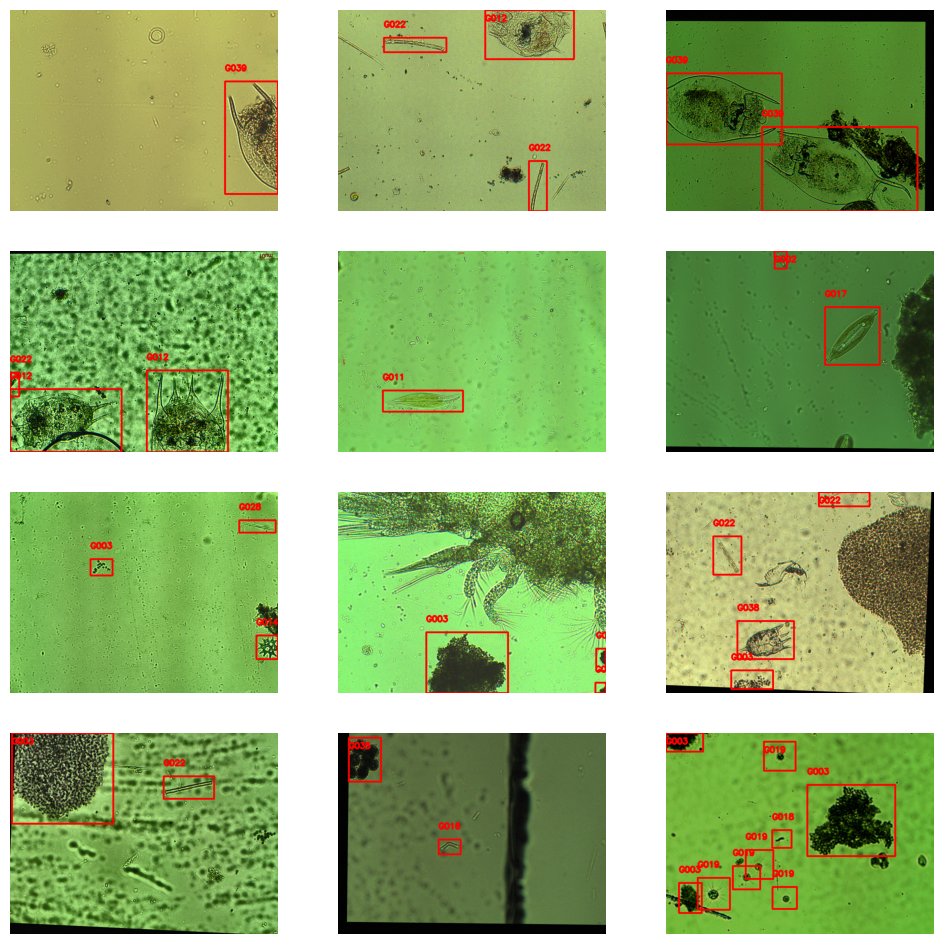

In [16]:
fig,axes=plt.subplots(4,3,figsize=(12,12))
ax=axes.flatten()
idxs=np.random.choice(len(train_ds),12,False)

for i,idx in enumerate(idxs):
    img,target=train_ds[idx]
    img=show_bbox(img,target)
    ax[i].imshow(img)
    ax[i].axis("off")

# DataLoader

In [17]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [18]:
train_dl=DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=os.cpu_count(),
                    collate_fn=collate_fn,pin_memory=True if device=="cuda" else False)
val_dl=DataLoader(val_ds,batch_size=batch_size,shuffle=False,num_workers=os.cpu_count(),
                  collate_fn=collate_fn,pin_memory=True if device=="cuda" else False)

# Model

In [19]:
weights=SSDLite320_MobileNet_V3_Large_Weights.DEFAULT
model=ssdlite320_mobilenet_v3_large(weights=weights,trainable_backbone_layers=4)

in_channels=det_utils.retrieve_out_channels(model.backbone,(750,1000))
num_anchors=model.anchor_generator.num_anchors_per_location()
model.head=SSDHead(in_channels=in_channels,num_anchors=num_anchors,
                   num_classes=len(classes))

model.to(device)

Downloading: "https://download.pytorch.org/models/ssdlite320_mobilenet_v3_large_coco-a79551df.pth" to /root/.cache/torch/hub/checkpoints/ssdlite320_mobilenet_v3_large_coco-a79551df.pth
100%|██████████| 13.4M/13.4M [00:00<00:00, 55.2MB/s]


SSD(
  (backbone): SSDLiteFeatureExtractorMobileNet(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (2): Hardswish()
        )
        (1): InvertedResidual(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (1): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            )
          )
        )
        (2): Invert

In [20]:
optimizer=optim.Adam(model.parameters(),lr=learning_rate)
lr_scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, 
                                                  patience=8, threshold=0.0001)

# Training

In [21]:
def get_lr(optimizer):
    for params in optimizer.param_groups:
        return params["lr"]

In [22]:
loss_history={"training_loss":[],
              "validation_loss":[]}

train_len=len(train_dl.dataset)
val_len=len(val_dl.dataset)

best_validation_loss=np.inf
best_weights=copy.deepcopy(model.state_dict())

for epoch in range(epochs):
    
    training_loss=0.0
    validation_loss=0.0
    
    current_lr=get_lr(optimizer)
    
    #During training, the model expects both the input tensors, as well as a targets 
    model.train()
    for imgs,targets in train_dl:
        imgs=[img.to(device) for img in imgs]
        targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]
        
        loss_dict=model(imgs,targets)
        losses=sum(loss for loss in loss_dict.values())
        training_loss+=losses.item()
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
    with torch.no_grad():
        for imgs,targets in val_dl:
            imgs=[img.to(device) for img in imgs]
            targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]
            
            loss_dict=model(imgs,targets)
            losses=sum(loss for loss in loss_dict.values())
            validation_loss+=losses.item()
        
            
    lr_scheduler.step(validation_loss)
    if current_lr!=get_lr(optimizer):
        print("Loading best Model weights")
        model.load_state_dict(best_weights)
    
    if validation_loss<best_validation_loss:
        best_validation_loss=validation_loss
        best_weights=copy.deepcopy(model.state_dict())
        print("Updating Best Model weights")
        
    
    loss_history["training_loss"].append(training_loss/train_len)
    loss_history["validation_loss"].append(validation_loss/val_len)
            
    print(f"\n{epoch+1}/{epochs}")
    print(f"Training Loss: {training_loss/train_len}")
    print(f"Validation_loss: {validation_loss/val_len}")
    print("\n"+"*"*50)

torch.save(best_weights,model_weights_file)

Updating Best Model weights

1/50
Training Loss: 2.855956174603742
Validation_loss: 1.8215971785531917

**************************************************
Updating Best Model weights

2/50
Training Loss: 1.5196962543980992
Validation_loss: 1.388529645221334

**************************************************
Updating Best Model weights

3/50
Training Loss: 1.2210385473213385
Validation_loss: 1.1994789949605162

**************************************************
Updating Best Model weights

4/50
Training Loss: 1.0943847150944952
Validation_loss: 1.098436988239557

**************************************************
Updating Best Model weights

5/50
Training Loss: 1.0083569169637576
Validation_loss: 1.0395489262862945

**************************************************
Updating Best Model weights

6/50
Training Loss: 0.9392635994289645
Validation_loss: 0.9919399281622658

**************************************************
Updating Best Model weights

7/50
Training Loss: 0.8909860479297923

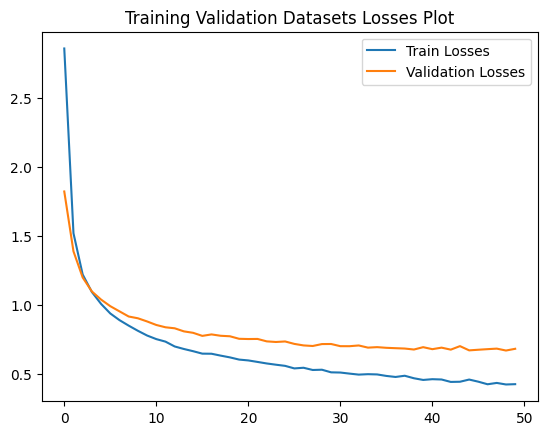

In [23]:
sns.lineplot(x=range(epochs),y=loss_history["training_loss"],label="Train Losses");
sns.lineplot(x=range(epochs),y=loss_history["validation_loss"],label="Validation Losses");
plt.title("Training Validation Datasets Losses Plot");

# Evaluation

In [24]:
learned_weights_pth="/kaggle/input/microorganism-detection/model.pth"

In [25]:
model=ssdlite320_mobilenet_v3_large(weights=None,weights_backbone=None)

in_channels=det_utils.retrieve_out_channels(model.backbone,(750,1000))
num_anchors=model.anchor_generator.num_anchors_per_location()
model.head=SSDHead(in_channels=in_channels,num_anchors=num_anchors,
                   num_classes=len(classes))

model.load_state_dict(torch.load(model_weights_file,map_location=device))
model.to(device)

SSD(
  (backbone): SSDLiteFeatureExtractorMobileNet(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (2): Hardswish()
        )
        (1): InvertedResidual(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (1): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            )
          )
        )
        (2): Invert

In [26]:
def preprocess_bbox(prediction):
    
    """Non-max suppression is the final step of these object detection algorithms and is 
       used to select the most appropriate bounding box for the object.
       The NMS takes two things into account
        -The objectiveness score is given by the model
        -The overlap or IOU of the bounding boxes"""
    
    processed_bbox={}
    
    boxes=prediction["boxes"][prediction["scores"]>=threshold]
    scores=prediction["scores"][prediction["scores"]>=threshold]
    labels=prediction["labels"][prediction["scores"]>=threshold]
    nms=torchvision.ops.batched_nms(boxes,scores,labels,iou_threshold=iou_threshold)
            
    processed_bbox["boxes"]=boxes[nms]
    processed_bbox["scores"]=scores[nms]
    processed_bbox["labels"]=labels[nms]
    
    return processed_bbox

In [27]:
metric=MeanAveragePrecision(box_format='xyxy',class_metrics=True)
metric.to(device)

model.eval()
with torch.no_grad():
    for imgs,targets in val_dl:
        imgs=[img.to(device) for img in imgs]
        targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]
        predictions=model(imgs)
        
        results=[]
        for prediction in predictions:
            results.append(preprocess_bbox(prediction))
        
        metric.update(results,targets)
        
results=metric.compute()

In [28]:
mean_ap=results["map"].item()
mean_ap_50=results["map_50"].item()
mean_ap_75=results["map_75"].item()

print(f"Mean Average Precision[0.5:0.95:0.05] : {mean_ap:.4f}")
print(f"Mean Average Precision @ 0.5          : {mean_ap_50:.4f}")
print(f"Mean Average Precision @ 0.75         : {mean_ap_75:.4f}")

Mean Average Precision[0.5:0.95:0.05] : 0.3676
Mean Average Precision @ 0.5          : 0.5386
Mean Average Precision @ 0.75         : 0.4491


In [29]:
if (len(results["map_per_class"])==len(results["classes"])):
    map_per_class=results["map_per_class"][1:].tolist()
    mar_100_per_class=results["mar_100_per_class"][1:].tolist()
    obj_cls=classes[1:]
else:
    map_per_class=results["map_per_class"].tolist()
    mar_100_per_class=results["mar_100_per_class"].tolist()
    obj_cls=classes[1:]
    
data=list(zip(map_per_class,mar_100_per_class))
columns=["Mean_Avg_Precision","Mean_Avg_Recall"]
cls_map=pd.DataFrame(data,columns=columns,index=classes[1:len(results["classes"])])
cls_map.style.background_gradient(subset=columns,cmap="YlOrRd",high=0.75)

# Inference

In [30]:
iterator=iter(val_dl)

Text(0.5, 1.0, 'Predicted Bounding Box')

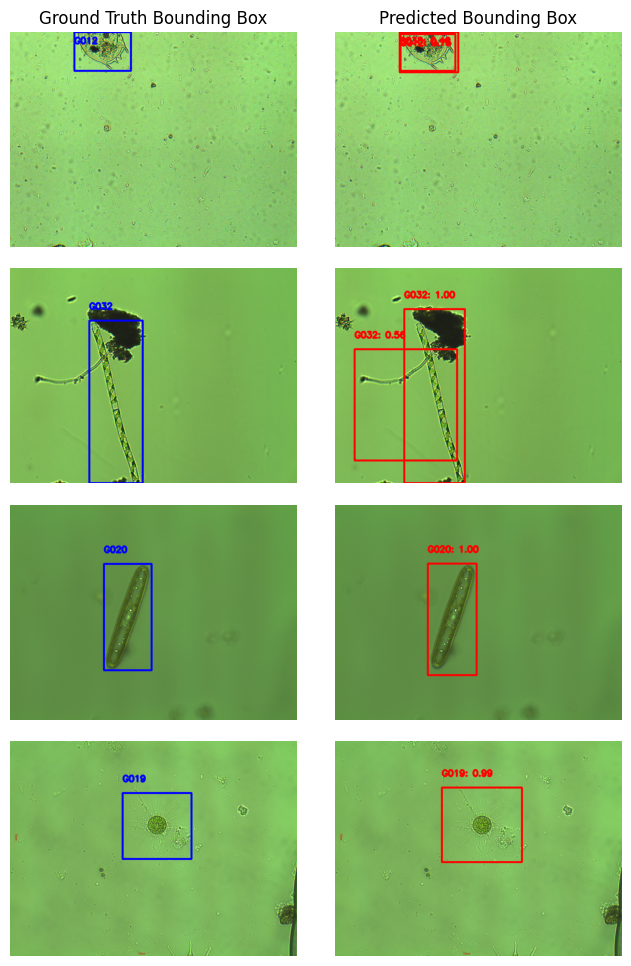

In [31]:
"""During inference, the model requires only the input tensors, and returns the 
   post-processed predictions as a List[Dict[Tensor]], one for each input image. The fields
   of the Dict are as follows:
   - boxes (FloatTensor[N, 4]): the predicted boxes in [x0, y0, x1, y1] format
   - labels (Int64Tensor[N]): the predicted labels for each image
   - scores (Tensor[N]): the scores or each prediction"""

fig,axes=plt.subplots(4,2,figsize=(8,12))
plt.subplots_adjust(wspace=0.1,hspace=0.1)

imgs,targets=next(iterator)
model.eval()
with torch.no_grad():
    output=model([img.to(device) for img in imgs])

for i,idx in enumerate(range(len(imgs))):
    img=imgs[idx]
    prediction=output[idx]
    
    #real bounding boxes
    output_img=show_bbox(img,targets[idx],color=(0,0,255));
    axes[i,0].imshow(output_img);
    axes[i,0].axis("off");
    
    #predicted bounding box
    predict=preprocess_bbox(prediction)
    output_img=show_bbox(img,predict,color=(255,0,0),detection=True);
    axes[i,1].imshow(output_img);
    axes[i,1].axis("off");
    
axes[0,0].set_title("Ground Truth Bounding Box")
axes[0,1].set_title("Predicted Bounding Box")

# Video Inference

In [32]:
video_path="/kaggle/input/microorganism-video/Microorganism.mp4"
video_out_path="/kaggle/working/output_video.mp4"

cap=cv2.VideoCapture(video_path)
if (cap.isOpened() == False):
    print('Error while trying to read video. Please check path again')
    
# define codec and create VideoWriter object 
out=cv2.VideoWriter(video_out_path, 
                    cv2.VideoWriter_fourcc(*'XVID'), 30, 
                    (480,480))

model=model.eval()

# read until end of video
while(cap.isOpened()):
    # capture each frame of the video
    ret, frame=cap.read()
    if ret==True:
        with torch.no_grad():
            # get predictions for the current frame
            frame=cv2.resize(frame,(480,480))
            frame=frame/255
            frame=np.transpose(frame,(2,0,1))
            frame=torch.as_tensor(frame,dtype=torch.float32)
            frame=frame.to(device)
            output=model([frame])
            predict=preprocess_bbox(output[0])
            output_img=show_bbox(frame,predict,color=(0,0,255),detection=True)
            output_img=(output_img*255).astype(np.uint8)
            out.write(output_img)
    else:
        break
        
# release VideoCapture()
out.release()
cap.release()

OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
